<a href="https://colab.research.google.com/github/Lxyyxxx/Colab/blob/main/REINFORCE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install loguru

     |████████████████████████████████| 57 kB 2.7 MB/s 


In [2]:
import tensorflow as tf
import gym
import matplotlib.pyplot as plt
from loguru import logger
from typing import Any

In [3]:
class REINFORCEModel(tf.keras.Model):
    def __init__(self, action_n: int) -> None:
        super().__init__()
        self.nn = [
            tf.keras.layers.Dense(30, activation='relu'),
            tf.keras.layers.Dense(30, activation='relu'),
            tf.keras.layers.Dense(action_n, activation='softmax'),
        ]

    def call(self, state: Any) -> Any:
        q = state
        for layer in self.nn:
            q = layer(q)
        return q

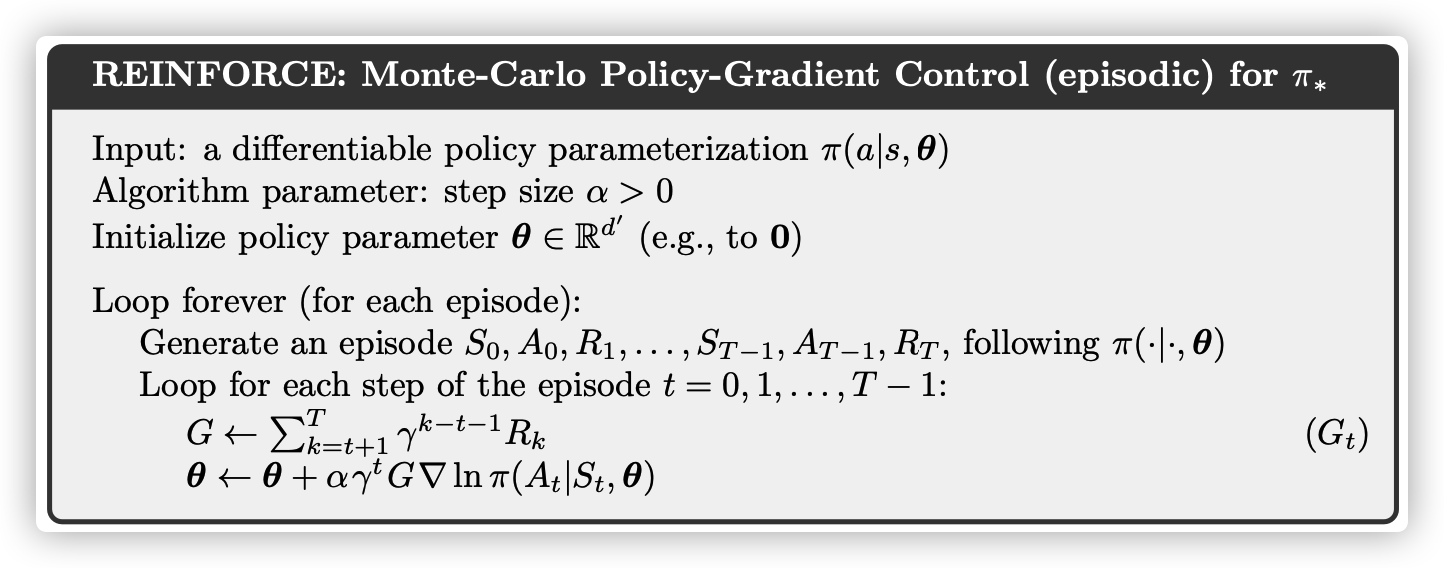

In [4]:
class REINFORCEAgent():
    def __init__(
        self,
        action_n: int,
        alpha: float = 0.01,
        gamma: float = 0.9,
    ) -> None:
        self.action_n = action_n
        self.alpha = alpha
        self.gamma = gamma
        self.model = REINFORCEModel(action_n)

    def predict(self, state: Any) -> int:
        state = tf.expand_dims(tf.convert_to_tensor(state), 0)
        action = tf.argmax(self.model(state), axis=1).numpy()[0]
        return action

    def learn(self, t: int, state: Any, action: int, G: float) -> None:
        with tf.GradientTape() as tape:
            state = tf.expand_dims(tf.convert_to_tensor(state), 0)
            action_probs = self.model(state)
            one_hot_actions = tf.one_hot([action], self.action_n)
            policy = tf.reduce_sum(tf.multiply(one_hot_actions, action_probs), axis=1)
            loss = tf.math.log(policy)
        grads = tape.gradient(loss, self.model.trainable_weights)
        for v, g in zip(self.model.trainable_weights, grads):
            v.assign_add(self.alpha * self.gamma ** t * G * g)

    def update_target(self) -> None:
        self.target_model.set_weights(self.model.get_weights())

    def save_model(self) -> None:
        self.model.save('reinforce')

    def load_model(self) -> None:
        self.model = tf.keras.models.load_model('reinforce')

In [5]:
def run_episode(env: gym.Wrapper, agent: REINFORCEAgent, training: bool, render: bool = False) -> float:
    state = env.reset()
    done = False
    step = 0
    score = 0
    rewards = []
    states = []
    actions = []
    # trajectory
    while not done:
        if render:
            env.render()
        step += 1
        action = agent.predict(state)
        state_, reward, done, info = env.step(action)
        score += reward
        rewards.append(reward)
        states.append(state)
        actions.append(action)
        state = state_
    # update
    if training:
        T = len(rewards)
        for t, (s, a, r) in enumerate(zip(states, actions, rewards)):
            # G
            G = 0
            for k in range(t + 1, T + 1):
                G += agent.gamma ** (k-t-1) * rewards[k-1]
            # theta
            agent.learn(t, s, a, G)
    return score

In [6]:
def train(env: gym.Wrapper, agent: REINFORCEAgent) -> None:
    score_result = []
    max_score = 0
    for episode in range(1000):
        score = run_episode(env, agent, training=True)
        score_result.append(score)
        if score > max_score:
            max_score = score
            logger.info('Episode {}: Best score {}'.format(episode, score))
        if score == max_score:
            agent.save_model()
        if episode % 50 == 0:
            logger.info('Episode {}: score {}'.format(episode, score))

    plt.title('Train Score Curve')
    plt.xlabel('Episode')
    plt.ylabel('Score')
    plt.plot(score_result, label='$Score$')
    plt.legend()
    plt.show()


def play(env: gym.Wrapper, agent: REINFORCEAgent) -> None:
    score_result = []
    agent.load_model()
    for episode in range(5):
        score = run_episode(env, agent, training=False, render=False)
        score_result.append(score)
        logger.info('Round {}: score: {}'.format(episode, score))

    plt.title('Play Score Curve')
    plt.xlabel('Round')
    plt.ylabel('Score')
    plt.plot(score_result, label='$Score$')
    plt.legend()
    plt.show()

2021-10-03 02:07:13.061 | INFO     | __main__:train:9 - Episode 0: Best score 61.0


INFO:tensorflow:Assets written to: reinforce/assets


2021-10-03 02:07:13.706 | INFO     | __main__:train:13 - Episode 0: score 61.0
2021-10-03 02:07:14.082 | INFO     | __main__:train:9 - Episode 1: Best score 83.0


INFO:tensorflow:Assets written to: reinforce/assets


2021-10-03 02:07:15.032 | INFO     | __main__:train:9 - Episode 2: Best score 107.0


INFO:tensorflow:Assets written to: reinforce/assets


2021-10-03 02:07:18.825 | INFO     | __main__:train:9 - Episode 13: Best score 123.0


INFO:tensorflow:Assets written to: reinforce/assets


2021-10-03 02:07:28.587 | INFO     | __main__:train:13 - Episode 50: score 107.0
2021-10-03 02:07:36.394 | INFO     | __main__:train:9 - Episode 80: Best score 143.0


INFO:tensorflow:Assets written to: reinforce/assets


2021-10-03 02:07:39.625 | INFO     | __main__:train:9 - Episode 88: Best score 153.0


INFO:tensorflow:Assets written to: reinforce/assets


2021-10-03 02:07:42.245 | INFO     | __main__:train:9 - Episode 94: Best score 156.0


INFO:tensorflow:Assets written to: reinforce/assets


2021-10-03 02:07:44.930 | INFO     | __main__:train:13 - Episode 100: score 46.0
2021-10-03 02:07:46.584 | INFO     | __main__:train:9 - Episode 104: Best score 163.0


INFO:tensorflow:Assets written to: reinforce/assets


2021-10-03 02:07:57.156 | INFO     | __main__:train:9 - Episode 137: Best score 199.0


INFO:tensorflow:Assets written to: reinforce/assets


2021-10-03 02:08:01.939 | INFO     | __main__:train:13 - Episode 150: score 64.0
2021-10-03 02:08:04.183 | INFO     | __main__:train:9 - Episode 154: Best score 200.0


INFO:tensorflow:Assets written to: reinforce/assets
INFO:tensorflow:Assets written to: reinforce/assets
INFO:tensorflow:Assets written to: reinforce/assets
INFO:tensorflow:Assets written to: reinforce/assets


2021-10-03 02:08:23.576 | INFO     | __main__:train:13 - Episode 200: score 121.0


INFO:tensorflow:Assets written to: reinforce/assets
INFO:tensorflow:Assets written to: reinforce/assets
INFO:tensorflow:Assets written to: reinforce/assets
INFO:tensorflow:Assets written to: reinforce/assets


2021-10-03 02:08:44.253 | INFO     | __main__:train:13 - Episode 250: score 170.0


INFO:tensorflow:Assets written to: reinforce/assets
INFO:tensorflow:Assets written to: reinforce/assets
INFO:tensorflow:Assets written to: reinforce/assets
INFO:tensorflow:Assets written to: reinforce/assets
INFO:tensorflow:Assets written to: reinforce/assets
INFO:tensorflow:Assets written to: reinforce/assets


2021-10-03 02:09:07.228 | INFO     | __main__:train:13 - Episode 300: score 59.0


INFO:tensorflow:Assets written to: reinforce/assets
INFO:tensorflow:Assets written to: reinforce/assets
INFO:tensorflow:Assets written to: reinforce/assets
INFO:tensorflow:Assets written to: reinforce/assets
INFO:tensorflow:Assets written to: reinforce/assets
INFO:tensorflow:Assets written to: reinforce/assets


2021-10-03 02:09:28.270 | INFO     | __main__:train:13 - Episode 350: score 51.0


INFO:tensorflow:Assets written to: reinforce/assets
INFO:tensorflow:Assets written to: reinforce/assets
INFO:tensorflow:Assets written to: reinforce/assets
INFO:tensorflow:Assets written to: reinforce/assets
INFO:tensorflow:Assets written to: reinforce/assets
INFO:tensorflow:Assets written to: reinforce/assets
INFO:tensorflow:Assets written to: reinforce/assets


2021-10-03 02:09:53.291 | INFO     | __main__:train:13 - Episode 400: score 88.0


INFO:tensorflow:Assets written to: reinforce/assets
INFO:tensorflow:Assets written to: reinforce/assets
INFO:tensorflow:Assets written to: reinforce/assets
INFO:tensorflow:Assets written to: reinforce/assets
INFO:tensorflow:Assets written to: reinforce/assets
INFO:tensorflow:Assets written to: reinforce/assets
INFO:tensorflow:Assets written to: reinforce/assets
INFO:tensorflow:Assets written to: reinforce/assets
INFO:tensorflow:Assets written to: reinforce/assets
INFO:tensorflow:Assets written to: reinforce/assets
INFO:tensorflow:Assets written to: reinforce/assets


2021-10-03 02:10:22.019 | INFO     | __main__:train:13 - Episode 450: score 200.0


INFO:tensorflow:Assets written to: reinforce/assets
INFO:tensorflow:Assets written to: reinforce/assets
INFO:tensorflow:Assets written to: reinforce/assets
INFO:tensorflow:Assets written to: reinforce/assets
INFO:tensorflow:Assets written to: reinforce/assets
INFO:tensorflow:Assets written to: reinforce/assets
INFO:tensorflow:Assets written to: reinforce/assets
INFO:tensorflow:Assets written to: reinforce/assets
INFO:tensorflow:Assets written to: reinforce/assets
INFO:tensorflow:Assets written to: reinforce/assets
INFO:tensorflow:Assets written to: reinforce/assets
INFO:tensorflow:Assets written to: reinforce/assets
INFO:tensorflow:Assets written to: reinforce/assets
INFO:tensorflow:Assets written to: reinforce/assets
INFO:tensorflow:Assets written to: reinforce/assets
INFO:tensorflow:Assets written to: reinforce/assets


2021-10-03 02:10:54.943 | INFO     | __main__:train:13 - Episode 500: score 75.0


INFO:tensorflow:Assets written to: reinforce/assets
INFO:tensorflow:Assets written to: reinforce/assets
INFO:tensorflow:Assets written to: reinforce/assets
INFO:tensorflow:Assets written to: reinforce/assets
INFO:tensorflow:Assets written to: reinforce/assets
INFO:tensorflow:Assets written to: reinforce/assets
INFO:tensorflow:Assets written to: reinforce/assets
INFO:tensorflow:Assets written to: reinforce/assets
INFO:tensorflow:Assets written to: reinforce/assets
INFO:tensorflow:Assets written to: reinforce/assets
INFO:tensorflow:Assets written to: reinforce/assets
INFO:tensorflow:Assets written to: reinforce/assets


2021-10-03 02:11:23.332 | INFO     | __main__:train:13 - Episode 550: score 65.0


INFO:tensorflow:Assets written to: reinforce/assets
INFO:tensorflow:Assets written to: reinforce/assets
INFO:tensorflow:Assets written to: reinforce/assets
INFO:tensorflow:Assets written to: reinforce/assets
INFO:tensorflow:Assets written to: reinforce/assets
INFO:tensorflow:Assets written to: reinforce/assets
INFO:tensorflow:Assets written to: reinforce/assets
INFO:tensorflow:Assets written to: reinforce/assets
INFO:tensorflow:Assets written to: reinforce/assets
INFO:tensorflow:Assets written to: reinforce/assets
INFO:tensorflow:Assets written to: reinforce/assets
INFO:tensorflow:Assets written to: reinforce/assets
INFO:tensorflow:Assets written to: reinforce/assets
INFO:tensorflow:Assets written to: reinforce/assets
INFO:tensorflow:Assets written to: reinforce/assets
INFO:tensorflow:Assets written to: reinforce/assets
INFO:tensorflow:Assets written to: reinforce/assets
INFO:tensorflow:Assets written to: reinforce/assets
INFO:tensorflow:Assets written to: reinforce/assets


2021-10-03 02:11:58.179 | INFO     | __main__:train:13 - Episode 600: score 200.0


INFO:tensorflow:Assets written to: reinforce/assets
INFO:tensorflow:Assets written to: reinforce/assets
INFO:tensorflow:Assets written to: reinforce/assets
INFO:tensorflow:Assets written to: reinforce/assets
INFO:tensorflow:Assets written to: reinforce/assets
INFO:tensorflow:Assets written to: reinforce/assets
INFO:tensorflow:Assets written to: reinforce/assets
INFO:tensorflow:Assets written to: reinforce/assets
INFO:tensorflow:Assets written to: reinforce/assets
INFO:tensorflow:Assets written to: reinforce/assets
INFO:tensorflow:Assets written to: reinforce/assets
INFO:tensorflow:Assets written to: reinforce/assets
INFO:tensorflow:Assets written to: reinforce/assets
INFO:tensorflow:Assets written to: reinforce/assets
INFO:tensorflow:Assets written to: reinforce/assets
INFO:tensorflow:Assets written to: reinforce/assets
INFO:tensorflow:Assets written to: reinforce/assets


2021-10-03 02:12:30.842 | INFO     | __main__:train:13 - Episode 650: score 129.0


INFO:tensorflow:Assets written to: reinforce/assets
INFO:tensorflow:Assets written to: reinforce/assets
INFO:tensorflow:Assets written to: reinforce/assets
INFO:tensorflow:Assets written to: reinforce/assets
INFO:tensorflow:Assets written to: reinforce/assets
INFO:tensorflow:Assets written to: reinforce/assets
INFO:tensorflow:Assets written to: reinforce/assets
INFO:tensorflow:Assets written to: reinforce/assets
INFO:tensorflow:Assets written to: reinforce/assets
INFO:tensorflow:Assets written to: reinforce/assets
INFO:tensorflow:Assets written to: reinforce/assets
INFO:tensorflow:Assets written to: reinforce/assets
INFO:tensorflow:Assets written to: reinforce/assets
INFO:tensorflow:Assets written to: reinforce/assets
INFO:tensorflow:Assets written to: reinforce/assets
INFO:tensorflow:Assets written to: reinforce/assets
INFO:tensorflow:Assets written to: reinforce/assets
INFO:tensorflow:Assets written to: reinforce/assets
INFO:tensorflow:Assets written to: reinforce/assets
INFO:tensorf

2021-10-03 02:13:07.155 | INFO     | __main__:train:13 - Episode 700: score 69.0


INFO:tensorflow:Assets written to: reinforce/assets
INFO:tensorflow:Assets written to: reinforce/assets
INFO:tensorflow:Assets written to: reinforce/assets
INFO:tensorflow:Assets written to: reinforce/assets
INFO:tensorflow:Assets written to: reinforce/assets
INFO:tensorflow:Assets written to: reinforce/assets
INFO:tensorflow:Assets written to: reinforce/assets
INFO:tensorflow:Assets written to: reinforce/assets
INFO:tensorflow:Assets written to: reinforce/assets
INFO:tensorflow:Assets written to: reinforce/assets
INFO:tensorflow:Assets written to: reinforce/assets
INFO:tensorflow:Assets written to: reinforce/assets
INFO:tensorflow:Assets written to: reinforce/assets
INFO:tensorflow:Assets written to: reinforce/assets
INFO:tensorflow:Assets written to: reinforce/assets
INFO:tensorflow:Assets written to: reinforce/assets
INFO:tensorflow:Assets written to: reinforce/assets
INFO:tensorflow:Assets written to: reinforce/assets


2021-10-03 02:13:41.172 | INFO     | __main__:train:13 - Episode 750: score 200.0


INFO:tensorflow:Assets written to: reinforce/assets
INFO:tensorflow:Assets written to: reinforce/assets
INFO:tensorflow:Assets written to: reinforce/assets
INFO:tensorflow:Assets written to: reinforce/assets
INFO:tensorflow:Assets written to: reinforce/assets
INFO:tensorflow:Assets written to: reinforce/assets
INFO:tensorflow:Assets written to: reinforce/assets
INFO:tensorflow:Assets written to: reinforce/assets
INFO:tensorflow:Assets written to: reinforce/assets
INFO:tensorflow:Assets written to: reinforce/assets
INFO:tensorflow:Assets written to: reinforce/assets
INFO:tensorflow:Assets written to: reinforce/assets
INFO:tensorflow:Assets written to: reinforce/assets
INFO:tensorflow:Assets written to: reinforce/assets
INFO:tensorflow:Assets written to: reinforce/assets


2021-10-03 02:14:12.320 | INFO     | __main__:train:13 - Episode 800: score 78.0


INFO:tensorflow:Assets written to: reinforce/assets
INFO:tensorflow:Assets written to: reinforce/assets
INFO:tensorflow:Assets written to: reinforce/assets
INFO:tensorflow:Assets written to: reinforce/assets
INFO:tensorflow:Assets written to: reinforce/assets
INFO:tensorflow:Assets written to: reinforce/assets
INFO:tensorflow:Assets written to: reinforce/assets
INFO:tensorflow:Assets written to: reinforce/assets
INFO:tensorflow:Assets written to: reinforce/assets
INFO:tensorflow:Assets written to: reinforce/assets
INFO:tensorflow:Assets written to: reinforce/assets
INFO:tensorflow:Assets written to: reinforce/assets
INFO:tensorflow:Assets written to: reinforce/assets
INFO:tensorflow:Assets written to: reinforce/assets
INFO:tensorflow:Assets written to: reinforce/assets
INFO:tensorflow:Assets written to: reinforce/assets
INFO:tensorflow:Assets written to: reinforce/assets
INFO:tensorflow:Assets written to: reinforce/assets


2021-10-03 02:14:45.290 | INFO     | __main__:train:13 - Episode 850: score 68.0


INFO:tensorflow:Assets written to: reinforce/assets
INFO:tensorflow:Assets written to: reinforce/assets
INFO:tensorflow:Assets written to: reinforce/assets
INFO:tensorflow:Assets written to: reinforce/assets
INFO:tensorflow:Assets written to: reinforce/assets
INFO:tensorflow:Assets written to: reinforce/assets
INFO:tensorflow:Assets written to: reinforce/assets
INFO:tensorflow:Assets written to: reinforce/assets
INFO:tensorflow:Assets written to: reinforce/assets
INFO:tensorflow:Assets written to: reinforce/assets
INFO:tensorflow:Assets written to: reinforce/assets
INFO:tensorflow:Assets written to: reinforce/assets
INFO:tensorflow:Assets written to: reinforce/assets
INFO:tensorflow:Assets written to: reinforce/assets
INFO:tensorflow:Assets written to: reinforce/assets
INFO:tensorflow:Assets written to: reinforce/assets
INFO:tensorflow:Assets written to: reinforce/assets
INFO:tensorflow:Assets written to: reinforce/assets
INFO:tensorflow:Assets written to: reinforce/assets
INFO:tensorf

2021-10-03 02:15:23.950 | INFO     | __main__:train:13 - Episode 900: score 82.0


INFO:tensorflow:Assets written to: reinforce/assets
INFO:tensorflow:Assets written to: reinforce/assets
INFO:tensorflow:Assets written to: reinforce/assets
INFO:tensorflow:Assets written to: reinforce/assets
INFO:tensorflow:Assets written to: reinforce/assets
INFO:tensorflow:Assets written to: reinforce/assets
INFO:tensorflow:Assets written to: reinforce/assets
INFO:tensorflow:Assets written to: reinforce/assets
INFO:tensorflow:Assets written to: reinforce/assets
INFO:tensorflow:Assets written to: reinforce/assets
INFO:tensorflow:Assets written to: reinforce/assets
INFO:tensorflow:Assets written to: reinforce/assets
INFO:tensorflow:Assets written to: reinforce/assets
INFO:tensorflow:Assets written to: reinforce/assets
INFO:tensorflow:Assets written to: reinforce/assets
INFO:tensorflow:Assets written to: reinforce/assets
INFO:tensorflow:Assets written to: reinforce/assets
INFO:tensorflow:Assets written to: reinforce/assets
INFO:tensorflow:Assets written to: reinforce/assets
INFO:tensorf

2021-10-03 02:16:01.437 | INFO     | __main__:train:13 - Episode 950: score 200.0


INFO:tensorflow:Assets written to: reinforce/assets
INFO:tensorflow:Assets written to: reinforce/assets
INFO:tensorflow:Assets written to: reinforce/assets
INFO:tensorflow:Assets written to: reinforce/assets
INFO:tensorflow:Assets written to: reinforce/assets
INFO:tensorflow:Assets written to: reinforce/assets
INFO:tensorflow:Assets written to: reinforce/assets
INFO:tensorflow:Assets written to: reinforce/assets
INFO:tensorflow:Assets written to: reinforce/assets
INFO:tensorflow:Assets written to: reinforce/assets
INFO:tensorflow:Assets written to: reinforce/assets
INFO:tensorflow:Assets written to: reinforce/assets
INFO:tensorflow:Assets written to: reinforce/assets
INFO:tensorflow:Assets written to: reinforce/assets
INFO:tensorflow:Assets written to: reinforce/assets
INFO:tensorflow:Assets written to: reinforce/assets
INFO:tensorflow:Assets written to: reinforce/assets
INFO:tensorflow:Assets written to: reinforce/assets
INFO:tensorflow:Assets written to: reinforce/assets
INFO:tensorf

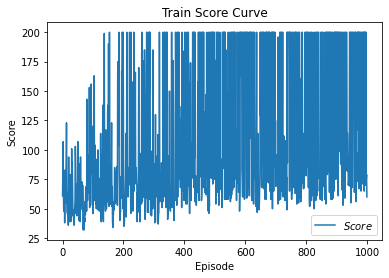

2021-10-03 02:16:41.952 | INFO     | __main__:play:29 - Round 0: score: 200.0
2021-10-03 02:16:42.022 | INFO     | __main__:play:29 - Round 1: score: 75.0
2021-10-03 02:16:42.196 | INFO     | __main__:play:29 - Round 2: score: 200.0
2021-10-03 02:16:42.286 | INFO     | __main__:play:29 - Round 3: score: 99.0
2021-10-03 02:16:42.462 | INFO     | __main__:play:29 - Round 4: score: 200.0


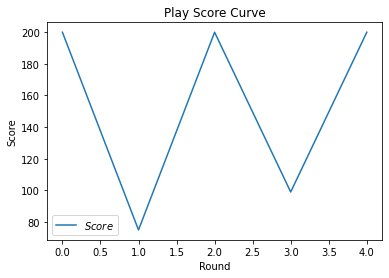

In [7]:
if __name__ == '__main__':
    env = gym.make('CartPole-v0')
    agent = REINFORCEAgent(env.action_space.n)
    # train
    train(env, agent)
    # play
    play(env, agent)